# 遊玩CartPolo

我們使用基因演算法，來優化強化學習代理人，進行CartPolo遊戲。

## 安裝gym環境

In [ ]:
!pip install gym[classic_control]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 18.3 MB 89 kB/s 


## 定義代理人

我們選擇神經網絡，作為代理人。

In [ ]:
import random 
import numpy as np
import torch

def model(x,unpacked_params):
  l1,b1,l2,b2,l3,b3 = unpacked_params #對參數向量進行拆解，將不同層的參數矩陣獨立出來
  y = torch.nn.functional.linear(x,l1,b1) #加入包含偏值的簡單線性層
  y = torch.relu(y) #以ReLU函數做為啟動函數
  y = torch.nn.functional.linear(y,l2,b2)
  y = torch.relu(y)
  y = torch.nn.functional.linear(y,l3,b3)
  y = torch.log_softmax(y,dim=0) #輸出各動作的對數化機率
  return y

## 參數變換

我們將神經網絡中的所有參數，都扁平化為一個向量，以便重組和突變。

In [ ]:
def unpack_params(params, layers=[(25,4),(10,25),(2,10)]): #定義每一層網路的矩陣形狀
  unpacked_params = [] #儲存每一層網路的權重及偏值
  e = 0
  for i,layer in enumerate(layers): #逐一走訪網路中的每一層
    s,e = e,e+np.prod(layer) #計算目前層權重資料的索引位置（由s到e），例如第一層，s = 0， e = 25x4 = 100  
    weights = params[s:e].view(layer) #取出目前層的權重參數並轉成矩陣形式，例如第一層會取出params[0:100]並轉成25x4的權重矩陣
    s,e = e,e+layer[0] # 計算目前層偏值資料的索引位置（由s到e），例如第一層，s = 100， e = 100+25 = 125
    bias = params[s:e] #取出目前層的偏值參數並轉成矩陣形式，例如第一層會取出params[100:125]並轉成1x25的偏值向量
    unpacked_params.extend([weights,bias]) #將獨立出來的張量存入串列中
  return unpacked_params

函數會依照每一層的shape，將參數向量中的參數，分配到不同層的"權重矩陣"和"偏值向量"中。

其實，也可以使用另一種做法: 將每一層神經層，看做一條"染色體"，且只允許來自同一條染色體(同一層神經元)的參數，進行重組。

這種"同層重組"的作法，可以避免後方神經層的資訊，影響到前面神經層的進化狀況。

實作中，可以利用迴圈，走訪每一層神經層，再分別讓不同層的參數，進行重組與突變。

## 產生族群

每一個代理人都是一個Python字典，其中存有:
* 參數向量
* 適應度分數

In [ ]:
def spawn_population(N,size): #N代表族群中的個體數量，size則是參數向量的參數總數
  pop = []
  for i in range(N):
    vec = torch.randn(size) / 2.0 #隨機產生一個初始參數向量
    fit = 0
    p = {'params':vec, 'fitness':fit} #將參數向量和它的適應度分數存入字典中，代表一個代理人
    pop.append(p) #將代理人加入串列中
  return pop

## 基因重組

接受兩個代理人，並以它們為親代，來產生兩個後代。

In [ ]:
def recombine(x1,x2): #x1和x2代表『親代』代理人，資料型別為字典
  x1 = x1['params'] #將代理人的參數向量抽取出來
  x2 = x2['params']
  n = x1.shape[0] #取得參數向量的長度
  split_pt = np.random.randint(n) #隨機產生一整數，代表重組時的切割位置
  child1 = torch.zeros(n)
  child2 = torch.zeros(n)
  child1[0:split_pt] = x1[0:split_pt] #第一個後代是由x1的前段和x2的後段組合而成
  child1[split_pt:] = x2[split_pt:]
  child2[0:split_pt] = x2[0:split_pt] #第二個後代是由x2的前段和x1的後段組合而成
  child2[split_pt:] = x1[split_pt:]
  c1 = {'params':child1, 'fitness': 0.0} #{將新產生的兩個參數向量分別存入字典中，產生兩個後代代理人
  c2 = {'params':child2, 'fitness': 0.0}
  return c1, c2

## 基因突變

將參數向量中的數個參數，隨機替換成新值。

In [ ]:
def mutate(x, rate): #rate代表突變率
  x_ = x['params'] #取出參數向量
  num_to_change = int(rate * x_.shape[0]) #使用突變率來決定參數向量中有多少參數發生突變
  idx = np.random.randint(low=0,high=x_.shape[0],size=(num_to_change,)) #產生要替換數值的索引位置串列
  x_[idx] = torch.randn(num_to_change) / 10.0 #將參數向量中指定位置的參數，替換成標準常態分佈的隨機值
  x['params'] = x_
  return x

注意，在設置突變率時，一定要多加留意，盡可能在"保留舊資訊"與"引入新資訊"之間，取得平衡。

## 測試代理人

在CartPolo環境中，執行特定代理人來玩遊戲，並傳回遊戲結束前的總步數，作為遊戲得分。

In [ ]:
import gym
env = gym.make("CartPole-v0")

def test_model(agent):
  done = False
  state = torch.from_numpy(env.reset()).float()
  score = 0 #追蹤遊戲進行了多少步，並以此做為代理人的得分
  while not done: #只要遊戲還沒有輸便持續執行迴圈
    params = unpack_params(agent['params'])
    probs = model(state, params) #將代理人的參數套入模型中，並產生各動作的機率分佈
    action = torch.distributions.Categorical(probs=probs).sample() #依照各動作的機率分佈，隨機選擇一個動作
    state_, reward, done, info = env.step(action.item())
    state = torch.from_numpy(state_).float()
    score += 1 #追蹤遊戲進行了多少步，並以此做為代理人的得分
  return score

/usr/local/lib/python3.8/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


## 測試族群

對族群中的所有代理人，進行測試。

In [ ]:
def evaluate_population(pop):
  tot_fit = 0 #儲存族群的總適應度，可用來計算族群的平均適應度 
  for agent in pop: #測試族群中的每一位代理人
    score = test_model(agent) #在環境中執行代理人，評估其適應度
    agent['fitness'] = score #將代理人的適應度儲存起來
    tot_fit += score
  avg_fit = tot_fit / len(pop) #計算族群的平均適應度
  return pop, avg_fit

## 產生後代

這裡我們使用競賽式選擇的方式，來產生後代。

根據經驗，可以將競賽人數，設定為族群大小的20%。

In [ ]:
def next_generation(pop,mut_rate,tournament_size):
  new_pop = []
  lp = len(pop)
  while len(new_pop) < len(pop): #若後代族群尚未被填滿，則持續執行迴圈
    rids = np.random.randint(low=0,high=lp,size=(int(tournament_size*lp))) #選擇一定比例的族群個體組成子集（將它們的索引存到 rids）
    #從族群中挑選代理人組成代理人批次，並記錄這些代理人在原始族群中的索引值，以及它們的適應度。
    batch = np.array([[i,x['fitness']] for (i,x) in enumerate(pop) if i in rids]) 
    scores = batch[batch[:, 1].argsort()] #將批次中的代理人依照適應度由低至高排序
    i0, i1 = int(scores[-1][0]),int(scores[-2][0]) #順序位於最下方的代理人具有最高的適應度；此處選擇最末的兩個代理人做為親代
    parent0,parent1 = pop[i0],pop[i1]
    offspring_ = recombine(parent0,parent1) #將親代重組成後代
    child1 = mutate(offspring_[0], rate=mut_rate) #在放入後代族群前，對新代理人進行突變處理
    child2 = mutate(offspring_[1], rate=mut_rate)
    offspring = [child1, child2] # 適應度最高的兩個個體
    new_pop.extend(offspring)
  return new_pop

這裡使用了enumerate()函式，來追蹤子集內，代理人在原族群中的索引值，確保接下來可以找到它們的適應度。

## 訓練模型

進化過程中，第一世代是由許多隨機生成的參數向量所組成的。這些向量的適應度，有高有低。

為了維持遺傳多樣性，每個個體都有微小的機會(1%)，發生突變。

In [ ]:
num_generations = 20 #進化過程的世代數（經歷20代的繁衍）
population_size = 500 #每一代族群中的個體數
mutation_rate = 0.01 #突變率
pop_fit = []
pop = spawn_population(N=population_size,size=407) #產生初始族群
for i in range(num_generations):
  pop, avg_fit = evaluate_population(pop) #評估族群中每一個代理人的適應度（得分）
  pop_fit.append(avg_fit)
  pop = next_generation(pop, mut_rate=mutation_rate,tournament_size=0.2) #產生後代族群

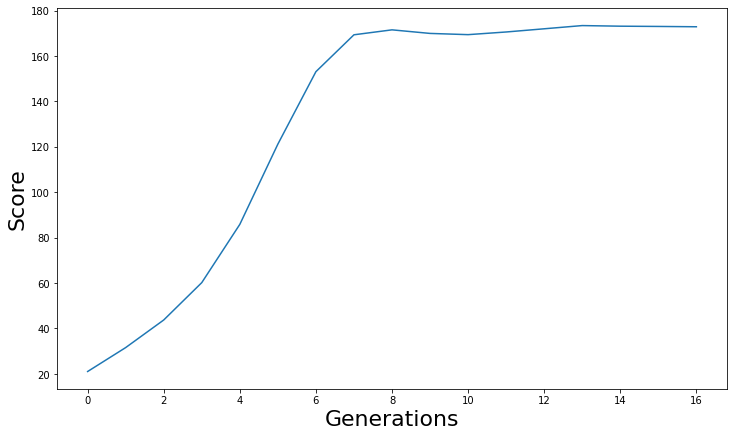

In [ ]:
def running_mean(x, N=50):
  kernel = np.ones(N)
  conv_len = x.shape[0]-N
  y = np.zeros(conv_len)
  for i in range(conv_len):
    y[i] = kernel @ x[i:i+N]
    y[i] /= N
  return y
    
plt.figure(figsize=(12,7))
plt.xlabel("Generations",fontsize=22)
plt.ylabel("Score",fontsize=22)
plt.plot(running_mean(np.array(pop_fit),3))

可以看到，隨著進化世代數的增加，代理人的遊戲得分，也在穩定上升。